In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 100)

import time
import datetime
from csv import reader
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand

from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules

In [ ]:
%pip install mlxtend --upgrade

>**APRIORI**


Алгоритм спочатку виокремлює **часті набори** елементів, по яким будуються асоціативні правила. Апріорний алгоритм був розроблений для роботи з базами даних, що містять транзакції. Набір елементів вважається "частим", якщо він відповідає визначеному користувачем порогу підтримки. Наприклад, якщо цей поріг 0.5, набір частих елементів визначається як набір елементів, які зустрічаються разом принаймні в 50% усіх транзакцій.

**Асоціативне правило** є виразом імплікації у формі X→Y, де X і Y є непересічними наборами елементів. Наприклад, АП {Ікра}→{Хліб} припускає, що люди, які купують ікру, також, швидше за все, куплять хліб. 

Процедура є рекурсивною: ми розщепляємо частий набір на умову і наслідок, перевіряючи значущість отриманого АП. Для оцінки значущості є такі **метрики**:

- Підтримка АП (безумовна): support(A->C) = support(A+C), range: [0, 1]

- Достовірність (значущість) АП: confidence(A->C) = support(A+C) / support(A), range: [0, 1]

- Покращення: lift(A->C) = confidence(A->C) / support(C), range: [0, inf]

- leverage(A->C) = support(A->C) - support(A)*support(C), range: [-1, 1]

- conviction = [1 - support(C)] / [1 - confidence(A->C)], range: [0, inf]

>**FP-GROWTH**


Це алгоритм для пошуку частих наборів, він використовує так звану структуру даних FP-дерева без явного генерування наборів-кандидатів, що робить його особливо привабливим для великих наборів даних.

Для кожного елемента кожної відсортованої транзакції з вхідного
набору будуються вузли (структура, яка зберігає значення вузла і його підтримки, а також посилання на всі його
дочірні елементи). Потім будується умовне FP-дерево.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
loadbaskets = '/content/drive/My Drive/Colab Notebooks/Var_4_Market_Basket_Analysis_1.csv'

# df_from_csv = pd.read_csv(loadbaskets, delimiter=',', names=list(range(30))).dropna(axis='columns', how='all')
# df_from_csv.head()

Mounted at /content/drive


In [ ]:
with open(loadbaskets, 'r') as read_obj:
    csv_reader = reader(read_obj)
    list_of_rows = list(csv_reader)
    print(list_of_rows)

arr = list(np.concatenate(list_of_rows).flat)

id_basket=[]
for i in range(len(list_of_rows)):
  for j in range(len(list_of_rows[i])):
    id_basket.append(i)

[['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil'], ['burgers', 'meatballs', 'eggs'], ['chutney'], ['turkey', 'avocado'], ['mineral water', 'milk', 'energy bar', 'whole wheat rice', 'green tea'], ['low fat yogurt'], ['whole wheat pasta', 'french fries'], ['soup', 'light cream', 'shallot'], ['frozen vegetables', 'spaghetti', 'green tea'], ['french fries'], ['eggs', 'pet food'], ['cookies'], ['turkey', 'burgers', 'mineral water', 'eggs', 'cooking oil'], ['spaghetti', 'champagne', 'cookies'], ['mineral water', 'salmon'], ['mineral water'], ['shrimp', 'chocolate', 'chicken', 'honey', 'oil', 'cooking oil', 'low fat yogurt'], ['turkey', 'eggs'], ['turkey', 'fresh tuna', 'tomatoes', 'spaghetti', 'mineral water', 'black tea', 'salmon', 'eggs', 'chicken', 'extra d

In [ ]:
baskets = pd.DataFrame({'Transaction':id_basket,'Item':arr})
print(len(baskets['Item'].unique()))
# print(baskets['Item'].unique())
baskets 

120


,Transaction,Item
0,0,shrimp
1,0,almonds
2,0,avocado
3,0,vegetables mix
4,0,green grapes
...,...,...
29358,7499,green tea
29359,7500,eggs
29360,7500,frozen smoothie
29361,7500,yogurt cake


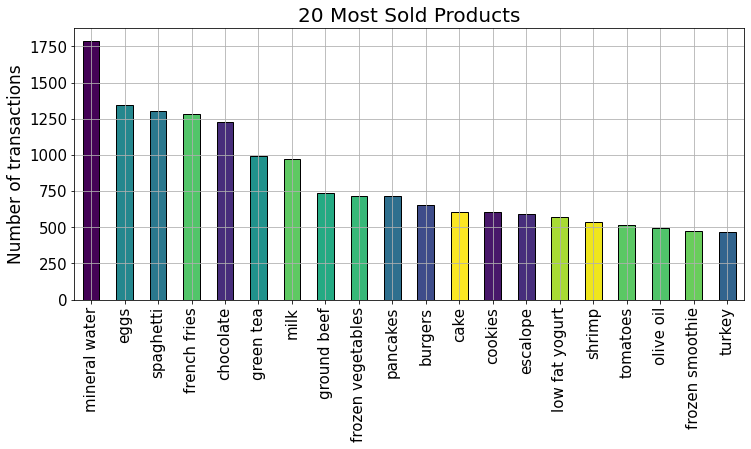

In [ ]:
fig, ax=plt.subplots(figsize=(12,5))
my_cmap = cm.get_cmap('viridis')
my_norm = Normalize(vmin=0, vmax=5)
baskets['Item'].value_counts().sort_values(ascending=False).head(20).plot.bar(width=0.5,edgecolor='k', color=my_cmap(my_norm(5*rand(20))),
                                                                              align='center',linewidth=1)
plt.ylabel('Number of transactions',fontsize=17)
ax.tick_params(labelsize=15)
plt.title('20 Most Sold Products',fontsize=20)
plt.grid()

In [ ]:
df = baskets.groupby(['Transaction', 'Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transaction')
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
encoded_df = df.applymap(encode_units)

encoded_df.head()

Item,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,bramble,brownies,bug spray,burger sauce,burgers,butter,cake,candy bars,carrots,cauliflower,cereals,champagne,chicken,chili,chocolate,chocolate bread,chutney,cider,clothes accessories,cookies,cooking oil,corn,cottage cheese,cream,dessert wine,eggplant,eggs,energy bar,energy drink,...,oil,olive oil,pancakes,parmesan cheese,pasta,pepper,pet food,pickles,protein bar,red wine,rice,salad,salmon,salt,sandwich,shallot,shampoo,shrimp,soda,soup,spaghetti,sparkling water,spinach,strawberries,strong cheese,tea,tomato juice,tomato sauce,tomatoes,toothpaste,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


>Шукаємо часті набори за алгоритмом **APRIOPI**, параметром є мінімальна підтримка набору min_support.
Будуємо асоціативні правила. min_threshold - мінімальний поріг для метрики оцінювання з metric

Спочатку підберемо такі параметри, що визначать максимально можливу множину значущих АП, метрикою є покращення lift: Improv(Rk) > 1. При цьому в min_threshold підбираємо поріг для метрики confidence

In [ ]:
params = [] # містить масиви з 3 параметрами
# цим масивам параметрів по індексам відповідають такі числа:
rules_num = [] # кількість правил, для яких lift>1 

for min_supp in range(1, 5): #мiнiмальна пiдтримка
  for min_conf in range(1, 6): #мiнiмальна достовiрність
    for max_len_set in range(2, 4): #максимальна потужність частих наборiв

      params.append([min_supp*0.01, min_conf*0.1, max_len_set])
      sets = apriori(encoded_df, min_support=min_supp*0.01, max_len=max_len_set, use_colnames=True)
      rules = association_rules(sets, metric='confidence', min_threshold=min_conf*0.1)
      rules_num.append(rules[rules.loc[:, 'lift'] > 1].shape[0])

print('Params for Apriori:', params[rules_num.index(max(rules_num))])

Params for Apriori: [0.01, 0.1, 3]


In [ ]:
start_time = time.time()
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)
sec = round(time.time() - start_time, 3)
print("Time used for Apriori:", str(datetime.timedelta(seconds=sec)))


print('Number of frequent itemsets:', frequent_itemsets.shape[0])
print(frequent_itemsets.sort_values(by=['support'], ascending=0).to_string(max_rows=15))

Time used for Apriori: 0:00:00.532000
Number of frequent itemsets: 257
      support                                  itemsets
46   0.238368                           (mineral water)
19   0.179709                                    (eggs)
63   0.174110                               (spaghetti)
24   0.170911                            (french fries)
13   0.163845                               (chocolate)
32   0.132116                               (green tea)
45   0.129583                                    (milk)
..        ...                                       ...
97   0.010265                  (cereals, mineral water)
232  0.010265                     (red wine, spaghetti)
255  0.010265     (spaghetti, olive oil, mineral water)
123  0.010132                         (soup, chocolate)
246  0.010132        (eggs, ground beef, mineral water)
249  0.010132  (french fries, mineral water, spaghetti)
175  0.010132       (frozen vegetables, low fat yogurt)


АП, відсортовані за метрикою lift:

In [ ]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)
rules.sort_values(by=['lift'], ascending=0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
185,(herb & pepper),(ground beef),0.049460,0.098254,0.015998,0.323450,3.291994,0.011138,1.332860
184,(ground beef),(herb & pepper),0.098254,0.049460,0.015998,0.162822,3.291994,0.011138,1.135410
306,"(spaghetti, mineral water)",(ground beef),0.059725,0.098254,0.017064,0.285714,2.907928,0.011196,1.262445
307,(ground beef),"(spaghetti, mineral water)",0.098254,0.059725,0.017064,0.173677,2.907928,0.011196,1.137902
313,"(spaghetti, mineral water)",(olive oil),0.059725,0.065858,0.010265,0.171875,2.609786,0.006332,1.128021
...,...,...,...,...,...,...,...,...,...
133,(mineral water),(french fries),0.238368,0.170911,0.033729,0.141499,0.827912,-0.007011,0.965741
128,(ground beef),(french fries),0.098254,0.170911,0.013865,0.141113,0.825652,-0.002928,0.965306
52,(cookies),(chocolate),0.080389,0.163845,0.010399,0.129353,0.789486,-0.002773,0.960384
93,(escalope),(eggs),0.079323,0.179709,0.011065,0.139496,0.776230,-0.003190,0.953267


Час виконання Apriori може бути досить великим, особливо для наборів даних із великою кількістю унікальних елементів, оскільки час виконання зростає експоненціально залежно від кількості унікальних елементів. 

На відміну від Apriori, FP-Growth – це алгоритм “вирощування частих наборів”, який вставляє елементи в дерево пошуку, має лінійне збільшення часу виконання. Хоча побудова дерева є також витратною за часом операцією

In [ ]:
params = []
rules_num = []

for min_supp in range(1, 5): #мiнiмальна пiдтримка
  for min_conf in range(1, 6): #мiнiмальна достовiрність
    for max_len_set in range(2, 4): #максимальна потужність частих наборiв

      params.append([min_supp*0.01, min_conf*0.1, max_len_set])
      fsets = fpgrowth(encoded_df, min_support=min_supp*0.01, max_len=max_len_set, use_colnames=True)
      rules = association_rules(fsets, metric='confidence', min_threshold=min_conf*0.1)
      rules_num.append(rules[rules.loc[:, 'lift'] > 1].shape[0])

print('Params for FPGrowth:', params[rules_num.index(max(rules_num))])

Params for FPGrowth: [0.01, 0.1, 3]


Алгоритм побудови FP-дерева дав такий самий результат, але за трохи більший час - в даному випадку це пояснюється невеликим розміром бази даних

In [ ]:
start_time = time.time()
fp_itemsets = fpgrowth(encoded_df, min_support=0.01, use_colnames=True)
sec = round(time.time() - start_time, 3)
print("Time used for FPGrowth:", str(datetime.timedelta(seconds=sec)))


print('Number of frequent itemsets:', fp_itemsets.shape[0])
print(fp_itemsets.sort_values(by=['support'], ascending=0).to_string(max_rows=15))

Time used for FPGrowth: 0:00:00.220000
Number of frequent itemsets: 257
      support                                  itemsets
0    0.238368                           (mineral water)
15   0.179709                                    (eggs)
26   0.174110                               (spaghetti)
22   0.170911                            (french fries)
31   0.163845                               (chocolate)
1    0.132116                               (green tea)
19   0.129583                                    (milk)
..        ...                                       ...
256  0.010265                  (cereals, mineral water)
104  0.010265     (spaghetti, olive oil, mineral water)
209  0.010265                     (red wine, spaghetti)
86   0.010132       (frozen vegetables, low fat yogurt)
156  0.010132  (french fries, mineral water, spaghetti)
160  0.010132                         (soup, chocolate)
236  0.010132        (eggs, ground beef, mineral water)


In [ ]:
rules_fp = association_rules(fp_itemsets, metric='confidence', min_threshold=0.1)
rules_fp.sort_values(by=['lift'], ascending=0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
297,(herb & pepper),(ground beef),0.049460,0.098254,0.015998,0.323450,3.291994,0.011138,1.332860
296,(ground beef),(herb & pepper),0.098254,0.049460,0.015998,0.162822,3.291994,0.011138,1.135410
276,(ground beef),"(spaghetti, mineral water)",0.098254,0.059725,0.017064,0.173677,2.907928,0.011196,1.137902
275,"(spaghetti, mineral water)",(ground beef),0.059725,0.098254,0.017064,0.285714,2.907928,0.011196,1.262445
53,(olive oil),"(spaghetti, mineral water)",0.065858,0.059725,0.010265,0.155870,2.609786,0.006332,1.113898
...,...,...,...,...,...,...,...,...,...
135,(french fries),(mineral water),0.170911,0.238368,0.033729,0.197348,0.827912,-0.007011,0.948894
272,(ground beef),(french fries),0.098254,0.170911,0.013865,0.141113,0.825652,-0.002928,0.965306
181,(cookies),(chocolate),0.080389,0.163845,0.010399,0.129353,0.789486,-0.002773,0.960384
294,(escalope),(eggs),0.079323,0.179709,0.011065,0.139496,0.776230,-0.003190,0.953267


Виведемо АП, для яких метрики lift >= 1 та confidence >= 0.4, отримали 18 прогнозів

In [ ]:
rules_fp[(rules_fp['lift'] >= 1) & (rules_fp['confidence'] >= 0.4)].sort_values(by=['lift'], ascending=0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
274,"(mineral water, ground beef)",(spaghetti),0.040928,0.174110,0.017064,0.416938,2.394681,0.009938,1.416470
285,"(ground beef, eggs)",(mineral water),0.019997,0.238368,0.010132,0.506667,2.125563,0.005365,1.543848
278,"(ground beef, milk)",(mineral water),0.021997,0.238368,0.011065,0.503030,2.110308,0.005822,1.532552
281,"(chocolate, ground beef)",(mineral water),0.023064,0.238368,0.010932,0.473988,1.988472,0.005434,1.447937
175,"(frozen vegetables, milk)",(mineral water),0.023597,0.238368,0.011065,0.468927,1.967236,0.005440,1.434136
145,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,0.011020,1.401255
249,"(spaghetti, pancakes)",(mineral water),0.025197,0.238368,0.011465,0.455026,1.908923,0.005459,1.397557
50,"(spaghetti, olive oil)",(mineral water),0.022930,0.238368,0.010265,0.447674,1.878079,0.004799,1.378954
113,"(spaghetti, milk)",(mineral water),0.035462,0.238368,0.015731,0.443609,1.861024,0.007278,1.368879
117,"(chocolate, milk)",(mineral water),0.032129,0.238368,0.013998,0.435685,1.827780,0.006340,1.349656


Можемо побачити взаємозв'язок між метриками підтримки і достовірності. Достовірність АП A->C — це ймовірність побачити набір С у транзакції, враховуючи, що воно також містить А. Підтримка ж використовується для вимірювання частоти набору, що містить А і С

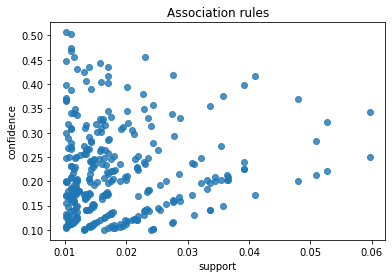

In [ ]:
support = rules_fp['support'].to_numpy()
confidence = rules_fp['confidence'].to_numpy()

    
plt.title('Association rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns.regplot(x=support, y=confidence, fit_reg=False)